In [34]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from torch.autograd import Variable
import torch.nn.functional as F

import gym
import cv2
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from rq import Queue
from redis import Redis
import PIL

from IPython.display import HTML, display
import imageio
import random
import sys
import os
import time
import pickle
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ga_model import *

def to_np(x):
    return x.data.cpu().numpy()

# Gym stuff

In [35]:
env = gym.make('SpaceInvadersDeterministic-v4')

[2018-03-26 11:41:04,730] Making new env: SpaceInvadersDeterministic-v4


Discrete(6)


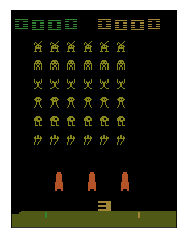

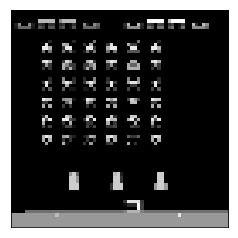

In [36]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    if len(im.shape) == 2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def render(env, converted=False):
    state = env.render(mode='rgb_array')
    if converted:
        state = convert_state(state)
    plt.show(show_img(state))
    
reset(env)
print(env.action_space)
render(env)
render(env, converted=True)

# Model

> We use the larger DQN architecture from Mnih et al. (2015) consisting of 3 convolutional layers with 32, 64, and 64 channels followed by a hidden layer
with 512 units. The convolutional layers use 8 × 8, 4 × 4, and 3 × 3 filters with strides of 4, 2, and 1, respectively. All hidden layers were followed by a rectifier nonlinearity (ReLU). The network contains over 4M parameters.

In [37]:
states = []
for _ in range(4):
    states.append(step(env, env.action_space.sample())[0])

In [38]:
m = Model(random_state())
print('first try')
print(to_np(m(Variable(torch.Tensor([states])))))
print('didn\'t change anything, should be the same')
print(to_np(m(Variable(torch.Tensor([states])))))
m.evolve(0.005, random_state())
print('after evolution, should be different but only slightly')
print(to_np(m(Variable(torch.Tensor([states])))))

m2 = uncompress_model(m.compress())
print('copied model, should be the same')
print(to_np(m2(Variable(torch.Tensor([states])))))


first try
[[-0.43856144 -0.0032052   0.37007928  0.24318151 -0.18700857  0.18212035
   0.20661992 -0.2650184  -0.43949822  0.05589521 -0.17031707  0.02920251
  -0.05334435  0.01096148 -0.3786377   0.16450265  0.3785209   0.10662077]]
didn't change anything, should be the same
[[-0.43856144 -0.0032052   0.37007928  0.24318151 -0.18700857  0.18212035
   0.20661992 -0.2650184  -0.43949822  0.05589521 -0.17031707  0.02920251
  -0.05334435  0.01096148 -0.3786377   0.16450265  0.3785209   0.10662077]]
after evolution, should be different but only slightly
[[-0.388292    0.02910536  0.36644396  0.24477568 -0.13368751  0.22146353
   0.14402077 -0.23484252 -0.46857312  0.10140623 -0.19626912  0.07007302
  -0.11534999  0.01953054 -0.33342692  0.17973207  0.43680423  0.04127014]]
copied model, should be the same
[[-0.388292    0.02910536  0.36644396  0.24477568 -0.13368751  0.22146353
   0.14402077 -0.23484252 -0.46857312  0.10140623 -0.19626912  0.07007302
  -0.11534999  0.01953054 -0.33342692  

Ok great, it compiles.

# GA

## Simple Explanation of Genetic Algorithms

> A genetic algorithm (Holland, 1992; Eiben et al., 2003) evolves a population P of N individuals (here, neural network parameter vectors θ, often called genotypes). At every generation, each θi is evaluated, producing a fitness score (aka reward) F(θi). Our GA variant performs truncation selection, wherein the top T individuals become the parents of the next generation. To produce the next generation, the following process is repeated N-1 times: A parent is selected uniformly at random with replacement and is mutated by applying additive Gaussian noise to the parameter vector: θ' = θ + σε where ε ∼ N(0, I). The appropriate value of σ was determined empirically for each experiment, as described in Supplementary Information (SI) Table 3. The Nth individual is an unmodified copy of the best individual from the previous generation, a technique called elitism.

This seems fairly clear to me, but I will attempt to re-explain it: basically instead of generating a network randomly and modifying its weights using gradient descent, we generate a bunch of networks randomly, constituting a "generation", then evaluate them. Surely some of them will perform slightly better. We pick the one that performs the very best and keep it for the next generation. Then among the top few networks we create the new generation by copying them a bunch of times and modifying the weights of each copy slightly. Because only the top networks get chosen each time and because we keep changing the networks, it seems like our performance should keep increasing, and indeed it often does!

In our case, since we are focusing on Atari games, the population size is 5,000, the truncation threshold is 10 and the σ parameter is 0.005. The I parameter they mentioned simply means that it is sampled from a normal distribution with unit variance (I is the identity matrix).

So, when do we stop with the generations, you might ask? Uber is very clear that they stopped after 1 billion **frames**, not after a fixed number of generations, so we will make sure to keep track of the number of frames that we see and stop once we've passed 1 billion. As a reminder, there is a difference between a frame and a forward pass on a neural network, since it is standard to run 4 frames for every forward pass (ie the network only chooses an action every 4 frames). If you use a `Deterministic-v4` in OpenAI gym, this frame skipping with 4 frames is automatically implemented for you, so simply multiply the number of times you called `.step` by 4, and stop when that number reaches a billion.

## Model Compression

One interesting innovation that Uber provides in this paper is in neural network compression.

>We propose a novel method to store large parameter vectors compactly by representing each parameter vector as an initialization seed plus the list of random seeds that produce the series of mutations applied to θ. This innovation was essential to enabling GAs to work at the scale of deep neural networks, and we thus call it a Deep GA. This technique also has the benefit of offering a state-of-the-art compression method (Section 5).

As the quote above implies, we absolutely **need** to implement this compression, not because it is cool but because we will need to have workers on several different machines, passing neural networks to each other, and it is simply crucial to be able to serialize the neural nets efficiently so that they can be transfered quickly from one machine to another.

Fortunately, implementing this is very simple! As mentioned by the paper, it is simply about remembering the random seeds used each time we generated random numbers, ie we need to remember:
* The seed we used for initializing the network
* The seed we used every time we evolved the weights of the network.

That's it! Whenever we pass the network around, we simply send the seeds instead of the actual network and it is easy to recreate it by re-running initialization and evolution after setting each of the seeds properly.

The way to set a random seed using PyTorch is simply `torch.manual_seed`, to which you can pass a number. To make sure the random seeds were always different, I passed in a number generated by Python's `random.randint`, sampled from 0 to 2^31 - 1 (why this number you ask? Well I wasn't sure what numbers were allowable as random seeds, but this makes sure whatever I pass fits in a 32 bit signed integer, which I felt was almost certainly acceptable, while bigger numbers might not be).

**Learning: use random SEEDS, not random STATES.**

PyTorch also has a way to get its current random **state** using `torch.get_rng_state`, and to set it using `torch.set_rng_state`. At first I used this because there are a lot more possible random states than random seeds, so it seemed more "random" to me. The big problem is that each random state is already around 5kB in size (by contrast, a random seed is only 4 bytes, or 1,000 times less), which meant that my system quickly became very slow due to the large amount of data involved. Don't make the same mistake I did!


## Distributed Computing: Job Queues and Spot Instances

**Fair warning**: in this section I will assume you already know a bit about AWS or some other cloud provider like Google Cloud or Microsoft Azure. If you don't, it might be worthwhile to at least take a look at some tutorial for using AWS for deep learning (eg: https://towardsdatascience.com/how-to-set-up-a-deep-learning-environment-on-aws-with-keras-theano-b0f39e3d861c), or at least just be aware that you'll likely have to do some Googling because I will skip over some important basic things. 

Training a neural network using genetic algorithms is different from training it using gradient descent in the following way: with gradient descent we need to do a lot of math on a single network, while with a genetic algorithm we need to do much less math (just a forward pass, not forward and backward) on many networks. This makes it possible to train our GA neural network on a massive number of CPUs instead of on single GPUs. 

How massive are we talking though? Let's see what Uber has to say about that:

> The GA and ES are both faster than Q-learning and policy gradient methods when substantial distributed computation is available (here, 720 CPU cores across dozens of machines).

**720**? Wow. I tend to think my own hardware is fairly high-end and up to date, but even between my desktop and my laptop I have a grand total of 8 CPU cores...

So is this another one of these papers that use an amount of resources completely unaccessible to us normal mortals? Not so! We're just going to need to learn a bit more about infrastructure.

### Job Queues

Here's the thing, there is absolutely no way we're going to get 720 CPU cores on a single machine. More reasonably we can get 64 or a bit more. This means that if we want to process things as far as Uber did, we are going to need multiple machines.

For this, we are going to use the concept of a task queue, with a master (or manager) and workers. The master will put tasks onto the task queue, and the workers will take jobs from the queue, run them, and write the results back. The process can be seen in this diagram.

![Source: https://www.alberton.info/batching_vs_latency_and_jobqueue_models.html](https://www.alberton.info/images/articles/jobqueues/jobqueue1.png)

In our case, the jobs are evaluating the performance of the different neural networks in the current generation, and the outputs are simply the scores of each neural networks, as well as the number of frames they used. Another advantage of this architecture is that it allows us to put the master and the workers on different machines, which is useful for keeping costs low: we can put the master on a not very powerful but very reliable machine, while we can put the workers on machines that are very powerful but not as reliable. This way we get to keep our data (since everything is stored on the master), but can use unreliable cheap machines as workers.

The task queue library that we will use is [RQ](http://python-rq.org), which is a very easy to use library for task queues. It relies on the Redis database, which you can install quite simply on an Amazon instance.

All you need to do is to make sure that *all* the code necessary for your workers is in a `.py` file, not in a notebook, as RQ needs `.py` files to create worker processes. Your master can be in a notebook, however. You can import whatever parts of your `.py` you need in your master notebook.

Specifically the following should be in a `.py` file:
* The code for the neural network model
* The code for neural network compression/decompression
* A function for evaluating a neural network from a compressed model and an environment name that returns at least the score and the number of frames used

Your master code can then add a job to the queue using `job = rq.enqueue(...)` with the function in question and the arguments it should take, and it can letter get the result using `job.result`, which will be None if the function hasn't returned yet. You should make sure that your code is robust to jobs being dropped: if you don't get a result for a job for a long time, make sure it is being reenqued. Remember to pass **compressed** neural nets as arguments to `enqueue`, since these will need to be serialized and transfered over the network, it is important that they be small.

Once you have all of this, you should create an AWS instance for your master, a small-ish one is sufficient, personally I used a t2.medium. You can install any Linux you want on it, personally I used the non-deep learning Ubuntu 16.04 AMI. Then install all the dependencies for your agent, including redis-server, rq, pytorch etc. Once this is done, you should do the following things:

* Edit the security group of the master machine you just created to allow for redis connections. To make sure you don't expose your redis server to the world, you can limit the traffic to just that coming from inside the same security group. Starting now, make sure any other machine you create is in the same security group. Ideally you'd only enable redis traffic, but I was too lazy to find out exactly how, so I enabled all traffic from the security group like so:
![image.png](aws_security.png)
* Find out the private IP of your master machine (should be in the EC2 web interface) and create the following two files:
 * A file named `redis.conf` containing `bind <YOUR PRIVATE IP>`
 * A file named `settings.py` containing `REDIS_HOST = '<YOUR PRIVATE IP'`
* Run redis server: `nohup redis-server redis.conf&`. The `nohup` part makes sure the server will keep running even if your connection dies and the `&` at the end makes sure it runs in the background right away so you can do other stuff.
* Run an RQ worker using `rq worker -c settings`.
* Now **test** that this works by running your master code and making sure the jobs are indeed processed by the worker.
* Kill the worker, go back to the AWS interface, click on your instance and go to "Actions -> Images -> Create Image", this will allow you to create an AMI containing all the packages that you just installed, so that it will be easy to launch workers on other machines!

We can now go on to create the actual workers.

### AWS Spot Instances

As it turns out, getting access to lots of CPUs is fairly easy: the c5.18xlarge instance on AWS, for instance, contains a staggering 72 CPUs, 1/10th of what we need! With just 10 of these instances we'll have exactly the same amount of CPUs that Uber used. There is even an instance with 96 CPUs (the m5.24xlarge), but it is worth noting that its CPUs are slightly slower than the c5.18xlarge and its cost per CPU is slightly higher due to the fact that it also has a lot more memory, which we don't really need (the c5.18xlarge has 144 GB of memory and the m5.24xlarge has 384 GB, but as I recall I never used more than 5 GB on any machine I used...).

Ok so how much will it cost? Well, a single c5.18xlarge costs \$3.06 per hour in the US-West region (other regions should be in the same ballpark), and Uber claims that they were able to train their networks in about an hour using the equivalent of 10 c5.18xlarge, so training a single network should cost us \$30.60, assuming all goes smoothly. This is actually not so bad! But we can do much better using **spot instances**.

Spot instances are how Amazon deals with the fact that not all of their machines are reserved at any given time: they set up an auction for usage of the idle machines, and the highest bidder gets to access them. This makes for much lower prices, but there is a catch: the machine you are using may be taken away from you if someone beats your maximum bid or if Amazon has to fulfill a full-price request.

Additionally, the price you actually pay can be less predictable than with regular on-demand instances: the spot price of instances fluctuates as demand increases and decreases, and you are always paying the current spot price as long as it is lower than your maximum bid. So if an instance is trading at \$1 an hour and you bid \$2, you will probably pay \$1 at first but over time you might start paying \$1.50 an hour, or \$0.50 etc. Fortunately, the market for instances is stable enough now that this is not a big concern: if you are only using your instances for a few hours, most likely you will pay within 5% or so of the price you saw when you first created the spot instance.

Overall though, the design we described above is perfect for spot instances as you can have a "master" server running on a small on-demand instance and use however many high-CPU spot instances you want. If you wrote your code properly, it should be relatively immune to spot instances dying: it will just retry jobs and not lose data. As of this writing, a c5.18xlarge spot instance costs \$1.08, so almost 3x less than using an on-demand instance. This means that, optimistically, it should cost around \$11 to train on a single game. Note, however, that due to the fact that I trained on 3 games (Frostbite, Breakout and Space Invaders) and due to the many errors I made along the way, this whole experiment cost me around \$115, so try to be extra careful or make sure you're willing to spend around \$100 before you start doing this.

So how do you create a spot instance? Let's do that now! As a reminder, please make sure you are reasonably confident about your setup (ie you have created an AMI and you have confirmed that you can easily start running the system on another machine) before you do this.

In the EC2 panel, click on "Spot Requests" on the right and then on the "Request Spot Instances" button. You will be taken to this page:
![image.png](spot.png)

Many of the parameters you can keep as default, just remember to do the following:
* Select your total capacity (10 would give you what Uber used, but I personally chose to use 5 instances and simply wait for 2 hours instead of 1. You'll have to ssh into every machine so a lower number is more manageable).
* Select the AMI you just created.
* Remove the c3.large instance type from the instance type list, and add a c5.18xlarge instead. The select instance type window will actually show you all the instances that are available and their prices.
 * It is possible that another instance type will be more advantageous for you when you look. My advice when figuring out what instance is best is simply to divide the current spot price by the number of CPUs to find the cheapest instance per CPU. Note, however, that the instances whose name start with a "c" are compute-optimized, which typically means that their CPUs are faster than those on other instances, even when the number of cores is equal.
* Select the same availability zone as your master (maybe not necessary).
* Select the security group you previously created/edited.

Some optional things are to set your maximum price (the default is to bid the On-Demand price, which is what I would recommend anyway) and maybe to reserve your spot instance for a fixed duration (this way you are guaranteed that your instance won't be preempted for the next, say, 3 hours, but you might be paying more than with an ordinary spot instance).

Once this is done, you can log into the various spot instances and run the rq workers on them. This is the script I used to start 72 workers and have each write its log into a different file:

```
for i in {0..72}
do
nohup rq worker -c settings > $i&
done
```

Now, assuming you are running your master code on the master box, you should finally be making progress with your training!

### An Important Aside on Intel MKL

A very cool recent development in numerical computing is Intel MKL. This is an extremely fast math library developed by Intel which takes advantage of recent instructions and multithreading to perform numerical computations very quickly. It is used by PyTorch for CPU computations and helps reduce the difference between CPU and GPU performance for neural networks (though GPUs are still faster).

Unfortunately, MKL will cause problems for us! This is because it will automatically use several CPU cores for the forward pass of a single neural network, but we already set things up so that we use one CPU core per neural network. I found that this seemed to make things slower for this purpose, which is why I recommend disabling multithreading in MKL. This can be done by installing mkl-service in python (`conda install mkl-service`) and putting the following lines at the top of your worker file, before you import pytorch:

```
import mkl
mkl.set_num_threads(1)
```

In [51]:
REDIS_HOST = '172.31.13.10'  # TODO: you absolutely need to change this if you use this code.

class FakeJob:
    def __init__(self, j):
        self.result = j.result

class GA:
    def __init__(self, population, compressed_models=None, queue_name='default'):
        self.population = population
        self.models = [CompressedModel() for _ in range(population)] if compressed_models is None else compressed_models
        
        self.redis = Redis(REDIS_HOST)
        self.queue = Queue(connection=self.redis, name=queue_name)
        for j in self.queue.jobs:
            j.cancel()

    # Note: the paper says "20k frames", but there are 4 frames per network
    # evaluation, so we cap at 5k evaluations
    def get_best_models(self, env, max_eval=5000, max_noop=30):
        jobs = []
        for m in self.models:
            jobs.append(self.queue.enqueue(evaluate_model, env, m, max_eval=max_eval, max_noop=max_noop, ttl=650, timeout=600))
        last_enqueue_time = time.time()
        while True:
            for i in range(len(jobs)):
                if jobs[i].result is not None and not isinstance(jobs[i], FakeJob):
                    if random.random() < 0.001:
                        print(jobs[i].result)
                    jobs[i] = FakeJob(jobs[i])
                    
            def convert_result(j):
                if j.result is not None:
                    if j.result[0] == 0.0 and j.result[1] == max_eval * 4 and 'Breakout' in env:
                        return -1.0
                    return j.result[0]
                return None
            scores = [convert_result(j) for j in jobs]
            if None not in scores:
                break
            if time.time() - last_enqueue_time > 600:
                print(f'Reenqueuing unfinished jobs ({sum(x is None for x in scores)}).')
                for i in range(len(jobs)):
                    if jobs[i].result is None:
                        jobs[i].cancel()
                        jobs[i] = self.queue.enqueue(
                            evaluate_model, env, self.models[i], max_eval=max_eval, max_noop=max_noop, ttl=650, timeout=600)
                last_enqueue_time = time.time()
            time.sleep(1)
        used_frames = sum(j.result[1] for j in jobs)
        scored_models = list(zip(self.models, scores))
        scored_models.sort(key=lambda x: x[1], reverse=True)
        return scored_models, used_frames

    def evolve_iter(self, env, sigma=0.005, truncation=10, max_eval=5000, max_noop=30):
        scored_models, used_frames = self.get_best_models(env, max_eval=max_eval, max_noop=max_noop)
        scores = [s for _, s in scored_models]
        median_score = np.median(scores)
        mean_score = np.mean(scores)
        max_score = scored_models[0][1]
        scored_models = scored_models[:truncation]
        
        # Elitism
        self.models = [scored_models[0][0]]
        for _ in range(self.population):
            self.models.append(copy.deepcopy(random.choice(scored_models)[0]))
            self.models[-1].evolve(sigma)
            
        return median_score, mean_score, max_score, used_frames


In [40]:
def make_video(env, model, max_eval=200000, max_noop=30):
    env = gym.make(env)
    model = uncompress_model(model)
    noops = random.randint(0, max_noop)
    cur_states = [reset(env)] * 4
    total_reward = 0
    frames = [env.render(mode='rgb_array')]
    for _ in range(noops):
        cur_states.pop(0)
        new_state, reward, is_done, _ = step(env, 0)
        frames.append(env.render(mode='rgb_array'))
        total_reward += reward
        if is_done:
            return total_reward
        cur_states.append(new_state)

    model.eval()
    for _ in range(max_eval):
        values = model(Variable(torch.Tensor([cur_states])))[0]
        action = np.argmax(values.data.numpy()[:env.action_space.n])
        new_state, reward, is_done, _ = step(env, action)
        frames.append(env.render(mode='rgb_array'))
        total_reward += reward
        if is_done:
            break
        cur_states.pop(0)
        cur_states.append(new_state)

    return total_reward, frames

In [47]:
def run_env(env, do_run=True, render_vids=True):
    if do_run:
        ga = GA(5000)

        total_frames = 0
        all_results = [(0.0, 0.0, 0.0, 0, time.time())]
        while total_frames < 1_000_000_000:
            if 'Breakout' in env.spec.id and total_frames < 10_000_000:
                med, avg, M, frames = ga.evolve_iter(env.spec.id, max_eval=400)
            else:
                med, avg, M, frames = ga.evolve_iter(env.spec.id)
            total_frames += frames
            all_results.append((med, avg, M, frames, time.time()))
            print(f'Done with generation!\nMedian: {med}, average: {avg}, max: {M}, frames: {total_frames:,}')
        best_models = ga.get_best_models(env.spec.id)[0]
        pickle.dump(all_results, open(f'{env.spec.id}_process.pickle', 'wb'))
        pickle.dump(best_models, open(f'{env.spec.id}_best.pickle', 'wb'))
        
    
    
    best_models = pickle.load(open(f'{env.spec.id}_best.pickle', 'rb'))
    process = pickle.load(open(f'{env.spec.id}_process.pickle', 'rb'))
    
    if render_vids:
        videos = [make_video(env.spec.id, best_models[0][0]) for _ in range(30)]
        pickle.dump(videos, open(f'{env.spec.id}_videos.pickle', 'wb'))
    videos = pickle.load(open(f'{env.spec.id}_videos.pickle', 'rb'))
    
    def convert_vid(video):
        res = []
        for v in video:
            img = PIL.Image.fromarray(v)
            img = img.resize((320, 240))
            res.append(np.array(img))
        return res
    
    videos = [(s, convert_vid(v)) for s, v in videos]
    videos.sort(key=lambda x:x[0])
    best_score, best_vid = videos[-1]
    worst_score, worst_vid = videos[0]
    median_score, median_vid = videos[len(videos) // 2]
    print(f'Best score: {best_score}')
    gif_file = f'{env.spec.id}_best.gif'
    imageio.mimsave(gif_file, best_vid + [best_vid[-1]] * 10, fps=20)
    display(HTML(f'<img src="{gif_file}">'))

    print(f'Worst score: {worst_score}')
    gif_file = f'{env.spec.id}_worst.gif'
    imageio.mimsave(gif_file, worst_vid + [worst_vid[-1]] * 10, fps=20)
    display(HTML(f'<img src="{gif_file}">'))

    print(f'Median score: {median_score}')
    gif_file = f'{env.spec.id}_median.gif'
    imageio.mimsave(gif_file, median_vid + [median_vid[-1]] * 10, fps=20)
    display(HTML(f'<img src="{gif_file}">'))

    for idx, name in enumerate(['Median Score', 'Average Score', 'Max Score', 'Frames Per Run', 'Total Time']):
        if name == 'Frames':
            div = 5000
        else:
            div = 1
        sb.set_style("darkgrid")
        plt.plot(list(range(1, len(process))), [(p[idx] - process[0][idx]) / div for p in process[1:]])
        plt.xlabel('Generation')
        plt.ylabel(name)
        plt.savefig(f'{env.spec.id}_{name}.png')
        plt.show()


## Let's look at the results!

Finally, it's one or two hours later, depending on how many machines you chose to use, and we have results!

So how do we evaluate the performance of our agents? Well, Uber has a few things to say about that:
> Comparing our results with those from other algorithms fairly is extremely difficult, as such comparisons are inherently apples and oranges in many different ways. One important consideration is whether agents are evaluated on random starts (a random number of no-op actions), which is the regime they are trained on, or starts randomly sampled from human play, which tests for generalization (Nair et al., 2015). **Because we do not have a database of human starts to sample from**, our agents are evaluated with random starts. Where possible, we compare our results to those for other algorithms for which such random start results are available. That is true for DQN and ES, but not true for A3C, where we had to include results on human starts.

The emphasis on lacking a database of human starts is mine: I think this is too bad, and indeed there does not seem to be such a database and I think it would be great to build one.

Regardless, it sounds like the way we should evaluate our agent is simply using a random number of no-op operations before starting them, which is how we did training in the first place. The number of no-ops is not specified here but it is given as between 0 and 30 elsewhere, so that's what we'll do. Because there is this randomness aspect (not to mention the potential for random number generation within the individual Atari games), I decided to run the game 30 times and to display the best, worst, and median result. Here goes, for Frostbite:

[2018-03-26 11:44:30,778] Making new env: FrostbiteDeterministic-v4


Best score: 4570.0


Worst score: 160.0


Median score: 170.0


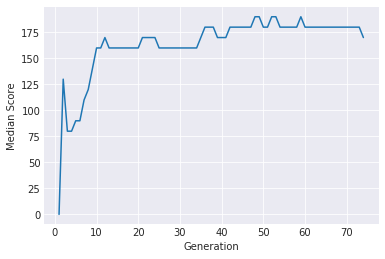

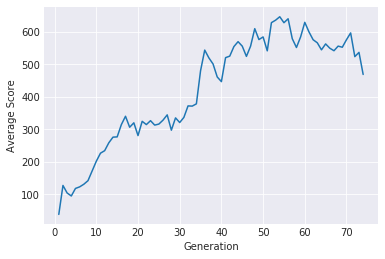

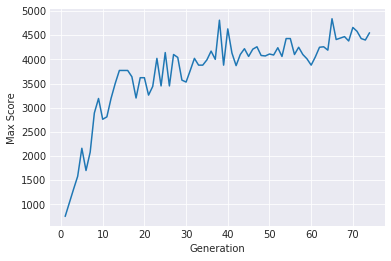

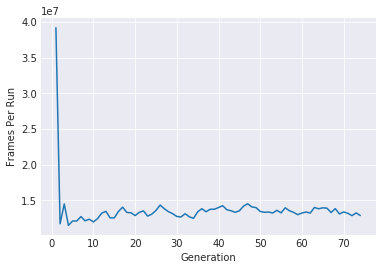

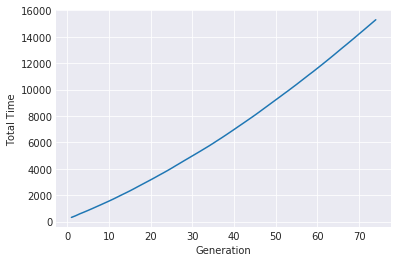

In [48]:
run_env(gym.make('FrostbiteDeterministic-v4'), False, False)

## Frostbite

We can see that we get an agent that performs very well for Frostbite: 4,570 as its best score, which is close to Uber's 4,801, and which is roughly the state of the art right now as far as I know! Very exciting.

Unfortunately, as we can see, the agent is not at all robust even to random starts! The median score is only 170 and the worst score is 160! It isn't clear to me why Uber did not report this: is it an issue in my implementation? Something that happened to them as well but that they failed to report? An issue in their implementation? (if they implemented random starts badly for instance, this might not be visible). 

This seems to explain the extremely large discrepancy between the median score and the best score as I go through generations (Uber's graph of "median" scores are not using this definition, which is why I can't really compare them to what I found: in Uber's definition it is the median of the best agent across multiple runs): it is not that agents are very sensitive to small changes in their weights, it is that they are very sensitive to small changes in their starting point!

I am really interested in fixing this issue in the future. In my mind, there are two things that could help fix this:
* Evaluating each neural net not on a single run but on several, each of which start with a different number of no-ops.
* Revisiting epsilon greedy for genetic algorithms: this seems crazy because it doesn't seem like GA "need" an exploration strategy, which is why Uber didn't implement one, but it could be that exploration doesn't just help reinforcement learning agents only with finding new high-reward states, but also with becoming robust to finding themselves in unforseen situations. Right now it seems like the GA networks are overfitting to a very specific sequence of actions from the game.

[2018-03-26 11:44:49,946] Making new env: BreakoutDeterministic-v4


Best score: 7.0


Worst score: 7.0


Median score: 7.0


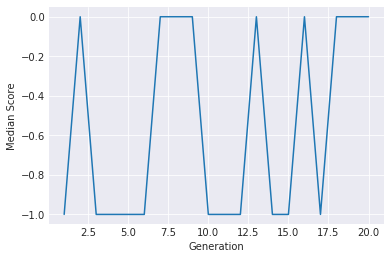

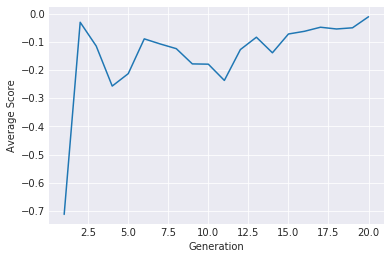

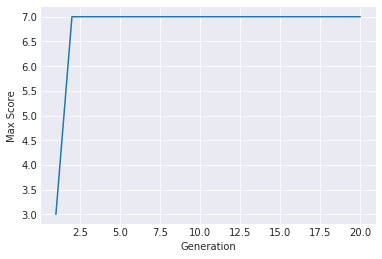

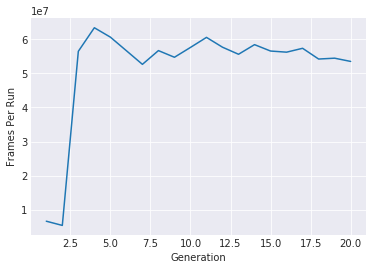

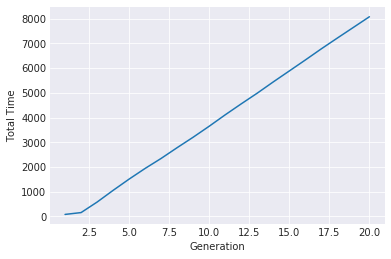

In [49]:
run_env(gym.make('BreakoutDeterministic-v4'), False, False)

### Breakout

Oh boy... GAs do **terribly** on Breakout. Why?

I can see a few reasons:
* You need to run a specific action or breakout won't start (specifically, breakout has 4 actions: do nothing, start the game, move left and move right).
 * This is not a problem when following a randomized exploration strategy such as epsilon-greedy, because the action will get chosen at some point or other, but without any exploration at all, it means that a large proportion of agents will simply do nothing forever.
 * To prevent this, I even made sure to reduce the maximum length of a game in the first few generations and to penalize agents that had done nothing at all the whole time. Obviously it didn't work that well, however.
* Very few of the pixels change in breakout, so agents keep performing the same action.
 * In Frostbite, almost 50% of the pixels are guaranteed to change even if the agent does nothing. In Breakout, only a tiny ball, the paddle, and maybe a brick or two will change, and only if the agent actually does something. For a randomly initialized neural network, this is likely not enough for it to decide to perform a different action.
 
Again, I think there are ways to fix this issue, including again including epsilon-greedy exploration in training. This warrants further exploration.

[2018-03-26 11:45:00,847] Making new env: SpaceInvadersDeterministic-v4


Best score: 1550.0


Worst score: 1550.0


Median score: 1550.0


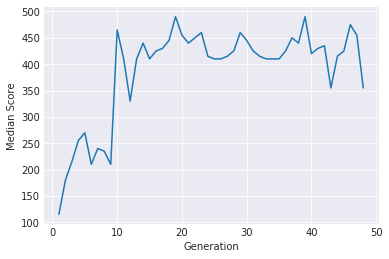

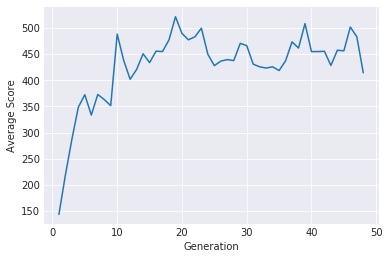

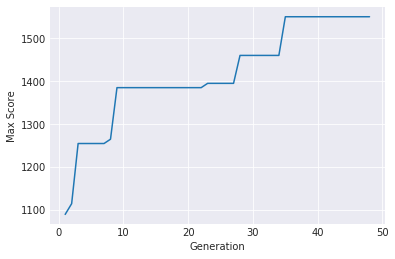

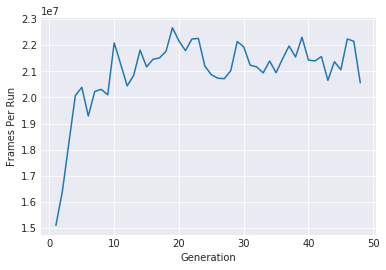

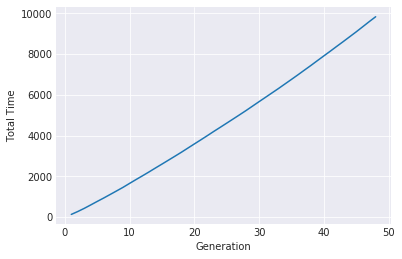

In [50]:
run_env(gym.make('SpaceInvadersDeterministic-v4'), False, False)

### Space Invaders

The agent does relatively well on space invaders, similar to the agent we trained in https://becominghuman.ai/beat-atari-with-deep-reinforcement-learning-part-2-dqn-improvements-d3563f665a2c, which is far from state of the art, but still pretty decent. Besides, it actually performs the same regardless of the initial random no-ops.

However, I am a bit concered about its strategy which consists, at least at first, in simply staying far to the left and trying to shoot the mothership: this looks more like a weird local optimum than an actual skill that the agent has obtained. Again I am curious what would make it learn something that looks more like real skill at the game and not a lazy strategy.

## Conclusion

I am excited about the results in Uber's paper. The fact that it does so well at Frostbite is quite amazing, and it is unclear to me if this means that traditional RL algorithms are particularly weak or that GA is surprisingly strong. I think, however, that there seem to be significant issues with GA that Uber doesn't point out, partly because they weren't able to evaluate their algorithms using a human-start database (which I think would have shown the brittleness of the various agents), and it would be interesting to try to fix these. I for one plan to try including epsilon-greedy exploration in the future, which I think will help with the robustness of the agents, and as Uber points out, there is a ton of literature available on genetic algorithms, and they only tried the most basic possible ones. Who knows where more advanced GAs will take us.